In [15]:
import pandas as pd

data = pd.read_csv("data/sp500_2015_2024_clean_tuning.csv", parse_dates = ["Date"], index_col = "Date")

print(data.head())
print(data.shape)

                  Close         High          Low         Open      Volume  \
Date                                                                         
2017-03-09  2364.870117  2369.080078  2354.540039  2363.489990  3718450000   
2017-03-10  2372.600098  2376.860107  2363.040039  2372.520020  3434400000   
2017-03-13  2373.469971  2374.419922  2368.520020  2371.560059  3166650000   
2017-03-14  2365.449951  2368.550049  2358.179932  2368.550049  3173760000   
2017-03-15  2385.260010  2390.010010  2368.939941  2370.340088  3909490000   

             Returns         MA20         MA50   Close_lag1   Close_lag5  \
Date                                                                       
2017-03-09  0.000800  2358.136011  2308.201196  2362.979980  2381.919922   
2017-03-10  0.003269  2361.372510  2310.275601  2364.870117  2383.120117   
2017-03-13  0.000367  2364.241003  2312.746602  2372.600098  2375.310059   
2017-03-14 -0.003379  2366.101001  2315.070400  2373.469971  2368.389893 

In [16]:
feature_cols = ["Close", "Returns", "MA10", "MA20", "MA50", "MA100", "Close_lag1", "Close_lag5", "Volume", "Vol20"]
X = data[feature_cols]
y = data["Close_tomorrow"]

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

split_ratio = 0.8
split_index = int(len(data) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [42]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [43]:
y_pred = rf.predict(X_test)

In [44]:
import numpy as np 
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

RMSE:  624.0621358215395


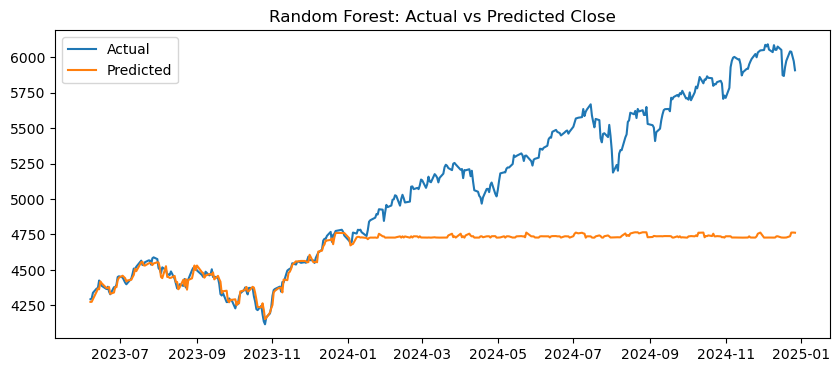

In [45]:
import matplotlib.pyplot as plt

test_dates = y_test.index

plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test, label = "Actual")
plt.plot(test_dates, y_pred, label = "Predicted")
plt.legend()
plt.title("Random Forest: Actual vs Predicted Close")
plt.show()

In [46]:
actual_dir = np.sign(y_test.values - X_test["Close"].values)
pred_dir = np.sign(y_pred - X_test["Close"].values)

direction_accuracy = (actual_dir == pred_dir).mean()
print("Direction accuracy: ", direction_accuracy)

Direction accuracy:  0.4631043256997455


In [47]:
position = (pred_dir > 0).astype(int)

actual_ret = ( y_test.values - X_test["Close"].values ) / X_test["Close"].values
strategy_ret = position * actual_ret

result = pd.DataFrame({"position" : position, "actual_ret" : actual_ret, "strategy_ret" : strategy_ret}, index = y_test.index)

cum_strategy = ( 1 + result["strategy_ret"]).cumprod()
cum_buyhold = ( 1 + result["actual_ret"]).cumprod()

print("Final multiple (strategy):", cum_strategy.iloc[-1])
print("Final multiple (buyhold):", cum_buyhold.iloc[-1])

Final multiple (strategy): 1.144063944936556
Final multiple (buyhold): 1.3841622099888984


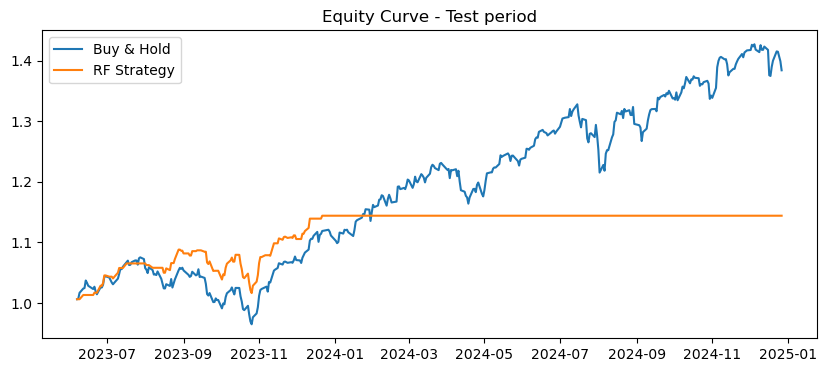

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(cum_buyhold, label = "Buy & Hold")
plt.plot(cum_strategy, label = "RF Strategy")
plt.legend()
plt.title("Equity Curve - Test period")
plt.show()

In [49]:
data.to_csv("data/sp500_2015_2024_clean_tuning_2.csv")